# Overview
準備する自転車の数を増加させ，割り当てを実行する

# What to do
- 割り当てモジュールに関してはoptimizationBasedDispatchModelを適用する．
- 自転車の数を変数として定義し，その自転車の数だけNYC内にランダムに自転車を配置する．
- 変数更新前にログデータを集計し，最終的にグラフで自転車の数・割り当て成功率・リバランスコストの関係を可視化する．

# 前提条件
これはあくまで自転車の初期配置数や制約条件となる割り当て可能半径がどれくらいが適切なのか全くわからない中で、少し明かりを灯してくれる立ち位置で行っている実験のため、そこまで厳密に結果を求めない。ざっくりと概要を知る。

## 定数

In [ ]:
# ライブラリのインストール
!pip install ortools

# デバッグ用
!pip install ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.2 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobu

In [ ]:
import branca.colormap as cm
import folium
import ipdb #デバッグ用
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
from ortools.linear_solver import pywraplp
from pandas import DataFrame

In [ ]:
# データの準備

'''locationID検索用CSV'''
df_locations = pd.read_csv('/content/taxi_zone_lookup_with_coordinates.csv')
# df_locations.set_index("LocationID", inplace=True)
print(df_locations.head())
print(df_locations.tail())

# 最後の2行を除外
df_locations = df_locations.iloc[:-2]

print("最後の2行を削除した後:")
print(df_locations.head())
print(df_locations.tail())

   LocationID        Borough                     Zone service_zone   Latitude  \
0           1            EWR           Newark Airport          EWR  40.689531   
1           2         Queens              Jamaica Bay    Boro Zone  40.603994   
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone  40.865229   
3           4      Manhattan            Alphabet City  Yellow Zone  40.725102   
4           5  Staten Island            Arden Heights    Boro Zone  40.563700   

   Longitude  
0 -74.174462  
1 -73.835412  
2 -73.842739  
3 -73.979583  
4 -74.191603  
     LocationID    Borough                Zone service_zone   Latitude  \
260         261  Manhattan  World Trade Center  Yellow Zone  40.711900   
261         262  Manhattan      Yorkville East  Yellow Zone  40.779282   
262         263  Manhattan      Yorkville West  Yellow Zone  40.777892   
263         264    Unknown                 NaN          NaN        NaN   
264         265        NaN      Outside of NYC       

In [ ]:
'''ユーザーリクエストの集合'''

STARTING_DATE = '2023-01-01 0:00'
END_DATE = '2023-01-02 0:00'

# ParquetファイルのURL
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

# Parquetファイルを読み込む
df = pd.read_parquet(url)

# 指定されたカラムのみを含むデータフレームを取得
df_requests = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID']]

# データのフィルタリング
# 2023年1月1日以前のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] >= STARTING_DATE]
# 2023年2月1日以降のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] < END_DATE]

# ピックアップタイムの昇順で並び替え
df_requests = df_requests.sort_values(by='tpep_pickup_datetime')

# インデックスをリセット
df_requests = df_requests.reset_index(drop=True)

# フィルタリングされたデータの先頭を表示
print(df_requests.head())

# データフレームの情報を表示
print(df_requests.info())

  tpep_pickup_datetime tpep_dropoff_datetime  PULocationID  DOLocationID
0  2023-01-01 00:00:00   2023-01-01 00:08:00            42            41
1  2023-01-01 00:00:05   2023-01-01 00:26:27           249           186
2  2023-01-01 00:00:06   2023-01-01 00:05:44           125            68
3  2023-01-01 00:00:08   2023-01-01 00:11:24            42           244
4  2023-01-01 00:00:09   2023-01-01 00:15:10            79           231
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76752 entries, 0 to 76751
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   76752 non-null  datetime64[us]
 1   tpep_dropoff_datetime  76752 non-null  datetime64[us]
 2   PULocationID           76752 non-null  int64         
 3   DOLocationID           76752 non-null  int64         
dtypes: datetime64[us](2), int64(2)
memory usage: 2.3 MB
None


In [ ]:
# optimizationBasedDispatchModelクラスを定義
# 制約条件となる最大割り当て可能半径を入力変数として追加する
class optimizationBasedDispatchModel():
  def __init__(self, df_locations, df_bikes, max_distance):
    self.df_locations = df_locations
    self.df_bikes = df_bikes
    self.max_distance = max_distance


  '''LocationIDから経度と緯度をタプルで返す関数'''
  def _get_coordinates_by_location_id(self, location_id):
    row = self.df_locations[self.df_locations['LocationID'] == location_id]
    if not row.empty:
        latitude = row.iloc[0]['Latitude']
        longitude = row.iloc[0]['Longitude']
        # 緯度と経度が有効な数値であるかどうかを確認する
        if pd.notna(latitude) and pd.notna(longitude):
            return (latitude, longitude)
        else:
            return None
    else:
        return None


  '''ユーザーリクエストJに対して移動後の自転車Bの位置関係を表す距離行列を返す関数'''
  def _generate_after_trip_distances(
      self,
      df_requests: DataFrame,
  ) -> np.ndarray:

      # 自転車とリクエストの数
      num_bikes = len(self.df_bikes)
      num_requests = len(df_requests)

      # 移動後の距離行列 d を作成 (d[b, j] が利用者 j が移動した後の自転車 b とその定位置までの距離)
      # 距離行列を初期化
      after_trip_distances = np.zeros((num_bikes, num_requests))
      for b in range(num_bikes):
          home_position = self.df_bikes.iloc[b].loc['Home Position']
          for j in range(num_requests):
              # df_requestsのj行目のDOLocationIDを取得する
              request_destination_id = df_requests.iloc[j].loc['DOLocationID']
              request_destination = self._get_coordinates_by_location_id(request_destination_id)
              # print("リクエストされたユーザーの目的地 位置座標:", request_destination)
              after_trip_distances[b, j] = geodesic(
                  home_position, request_destination
              ).m  # 単位はメートル

      # print('-----after_trip_distances-----')
      # print(after_trip_distances)
      return after_trip_distances


  '''ユーザーリクエストJに対して移動前の自転車Bの位置関係を表す距離行列を返す関数'''
  def _generate_before_trip_distances(
      self,
      df_requests: DataFrame,
  ) -> np.ndarray:

      # 自転車とリクエストの数
      num_bikes = len(self.df_bikes)
      num_requests = len(df_requests)

      # 移動前の距離行列 d を作成 (d[b, j] が利用者 j のリクエスト地点と自転車 b の現在地との距離)
      # 距離行列を初期化
      before_trip_distances = np.zeros((num_bikes, num_requests))
      for b in range(num_bikes):
          current_location = self.df_bikes.iloc[b].loc['Current Location']
          for j in range(num_requests):
              # df_requestsのj行目のPULocationIDを取得する
              request_pickup_id = df_requests.iloc[j].loc['PULocationID']
              request_pickup = self._get_coordinates_by_location_id(request_pickup_id)
              # print("リクエストされたユーザーの位置座標:", request_pickup)
              before_trip_distances[b, j] = geodesic(
                  current_location, request_pickup
              ).m  # 単位はメートル

      # print('-----before_trip_distances-----')
      # print(before_trip_distances)
      return before_trip_distances


  '''利用可能な自転車の集合を返す関数'''
  def _get_available_bikes(
      self,
      current_time: datetime = None
  ) -> np.ndarray:
      # current_timeがNoneの場合、現在時刻を取得
      # 本番運用時はcurrent_timeを利用しない
      if current_time is None:
          current_time = datetime.now()

      # 利用可能な自転車を1、不可能な自転車を0とする行列を作成
      available_bikes = (self.df_bikes['DODatetime'].isna() | (self.df_bikes['DODatetime'] < current_time)).astype(int)
      # available_bikes = ((self.df_bikes['DODatetime'] == pd.NaT) | (self.df_bikes['DODatetime'] < current_time)).astype(int)
      # print('-----available_bikes.values-----')
      # print(available_bikes.values)
      return available_bikes.values


  '''割り当て成功後の自転車ステータスの更新'''
  def _update_bike_status(
      self,
      bike_assignment,
      df_requests
  ):
      for b, j in bike_assignment:
          # jのtpep_dropoff_datetimeを取得するし自転車ステータス更新する
          # df_requestsのインデックスjに対応する行を取得
          request_row = df_requests.iloc[j]
          self.df_bikes.at[b, 'DODatetime'] = request_row['tpep_dropoff_datetime']
          # jのDOLocationIDを取得して自転車のCurrent Locationを更新する
          self.df_bikes.at[b, 'Current Location'] = self._get_coordinates_by_location_id(request_row['DOLocationID'])


  '''結果出力用メソッド'''
  def _print_results(self, result_dict):
      # 辞書型のそれぞれのデータに対して"key: value"形式で出力する
      for key, value in result_dict.items():
          print(f"{key}: {value}")
      # print("-------------------------------------------------------")

  '''最適化メイン処理'''
  def solve(self, df_requests):
    # ipdb.set_trace()  # ブレークポイントを設定
    # ユーザーリクエストJに対して移動された自転車Bにおける、自転車の定位置との距離行列
    distances = self._generate_after_trip_distances(df_requests)
    # ユーザーリクエストJに対してマッチングする前の自転車との距離行列
    initial_distances = self._generate_before_trip_distances(df_requests)

    # 利用可能な自転車を取得する
    # df_requestsの最終行のtpep_pickup_datetimeカラムの値を取得する
    current_time = df_requests.iloc[-1]['tpep_pickup_datetime']
    # print('-----current_time-----')
    # print(current_time)
    available_bikes = self._get_available_bikes(current_time)

    # 問題の正規化
    average = distances.mean()
    std = distances.std()
    distances: np.ndarray = (distances - average) / std


    # OR-Toolsのソルバーを作成
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # 変数の定義
    x = []
    for b in range(self.df_bikes.shape[0]):
        x.append([])
        for j in range(df_requests.shape[0]):
            x[b].append(solver.BoolVar(f'x[{b},{j}]'))

    alpha = 1.0

    # 目的関数の定義
    # 第一項: ユーザーの移動後の自転車の現在地と定位置との距離を短くする
    distance_objective = solver.Sum(distances[b][j] * x[b][j] for b in range(self.df_bikes.shape[0]) for j in range(df_requests.shape[0]))
    # 第二項: より多くのユーザーに自転車を割り当てる
    sum_x = solver.Sum(x[b][j] for b in range(self.df_bikes.shape[0]) for j in range(df_requests.shape[0]))

    objective = distance_objective - alpha * sum_x
    solver.Minimize(objective)

    # 制約条件の定義

    # 各ユーザーは1台の自転車にしか割り当てられない
    for b in range(self.df_bikes.shape[0]):
        solver.Add(solver.Sum(x[b][j] for j in range(df_requests.shape[0])) <= 1)

    # 各自転車は１人のユーザーにしか割り当てられない
    for j in range(df_requests.shape[0]):
        solver.Add(solver.Sum(x[b][j] for b in range(self.df_bikes.shape[0])) <= 1)

    # 入力変数(単位はメートル)
    R = self.max_distance
    # 半径r内に存在する自転車しかユーザーに割り当てない制約
    for b in range(self.df_bikes.shape[0]):
        for j in range(df_requests.shape[0]):
            if initial_distances[b][j] > R:
                solver.Add(x[b][j] == 0)

    # 他ユーザーに割り当てられていない利用可能な自転車のみを割り当てる
    for b in range(available_bikes.shape[0]):
        if available_bikes[b] == 0:
            for j in range(df_requests.shape[0]):
                solver.Add(x[b][j] == 0)

    # ipdb.set_trace()  # ブレークポイントを設定
    # ソルバーを実行
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # print('解が見つかりました:')
        bike_assignment = []
        for b in range(self.df_bikes.shape[0]):
            for j in range(df_requests.shape[0]):
                if x[b][j].solution_value() == 1:
                    bike_assignment.append((b, j))
                    # print(f"利用者 {j}: 自転車 {b}")
        self._update_bike_status(bike_assignment, df_requests)
        # _print_results()に結果を渡して出力する
        result_dict = {
            "Distance objective": distance_objective.solution_value(),
            "Sum of assignments": sum_x.solution_value(),
            "Objective value": objective.solution_value(),
            "bike_assignment": bike_assignment,
        }
        # self._print_results(result_dict) #←モデル検証・デバッグ用
        return bike_assignment #←モデル検証・デバッグ時はコメントアウトする。実際にはこれを返す。
    else:
        raise RuntimeError("No feasible solution was found.")


## 変数

In [ ]:
# ランダムなリクエストを選定する関数
def select_sample_ten_minute_requests(df_requests, seed=42):
    """
    与えられたリクエストデータからランダムに選択した開始時間から連続する10分間のリクエストを取得する。

    :param df_requests: リクエストを含むDataFrame。'timestamp'列が必要。
    :param seed: 乱数シード（再現性が必要な場合に指定）
    :return: 10分間のリクエストDataFrameを含む配列
    """
    if seed is not None:
        np.random.seed(seed)  # シード値を設定

    # tpep_pickup_datetimeをdatetime型に変換
    df_requests['tpep_pickup_datetime'] = pd.to_datetime(df_requests['tpep_pickup_datetime'])

    # リクエストデータを一分ごとに分割
    start_time = df_requests['tpep_pickup_datetime'].min()
    end_time = df_requests['tpep_pickup_datetime'].max()

    # 選択可能な最後の開始時間は終了時間から10分前
    latest_start_time = end_time - pd.Timedelta(minutes=10)

    # 0以上1430未満でランダムに1つの整数を生成し、開始時間を選択
    random_start_minute = np.random.randint(0, int((latest_start_time - start_time).total_seconds() / 60))
    random_start_time = start_time + pd.Timedelta(minutes=random_start_minute)

    # 選択した開始時間から連続する10分間のリクエストを抽出
    end_of_selection = random_start_time + pd.Timedelta(minutes=10)
    selected_requests = df_requests[(df_requests['tpep_pickup_datetime'] >= random_start_time) &
                                    (df_requests['tpep_pickup_datetime'] < end_of_selection)]

    return selected_requests


In [ ]:
# 関数をテスト
hogehoge = select_sample_ten_minute_requests(df_requests, 42)
hogehoge

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID
62132,2023-01-01 18:46:01,2023-01-01 18:56:17,262,233
62133,2023-01-01 18:46:03,2023-01-01 18:50:25,236,263
62134,2023-01-01 18:46:04,2023-01-01 18:56:39,140,137
62135,2023-01-01 18:46:04,2023-01-01 18:57:49,132,28
62136,2023-01-01 18:46:05,2023-01-01 19:20:49,114,100
...,...,...,...,...
62750,2023-01-01 18:55:57,2023-01-01 19:24:02,138,265
62751,2023-01-01 18:55:58,2023-01-02 18:49:16,161,125
62752,2023-01-01 18:55:58,2023-01-01 19:29:22,238,249
62753,2023-01-01 18:55:59,2023-01-01 19:08:38,237,238


In [ ]:
'''自転車の台数を引数として自転車の集合を生成する関数'''
def generate_bikes(df_locations, num_bikes, seed=42):

    if seed is not None:
        np.random.seed(seed)  # シード値を設定

    # ランダムシードを設定して、ランダムにnum_bikes個選択
    random_sample = df_locations.sample(n=num_bikes)
    print(random_sample)

    # Bike IDを設定
    random_sample['Bike ID'] = range(num_bikes)

    # 緯度と経度をホームポジションとカレントポジションに設定
    random_sample['Home Position'] = list(zip(random_sample['Latitude'], random_sample['Longitude']))
    random_sample['Current Location'] = random_sample['Home Position']

    # 結果のデータフレームを整形
    B = random_sample[['Bike ID', 'Home Position', 'Current Location']]
    B.set_index("Bike ID", inplace=True)

    # DODatetimeカラムを追加して初期値をNaTに設定
    B['DODatetime'] = pd.NaT

    return B


In [ ]:
# 異なる自転車の数と最大距離でシミュレーション
bike_counts = [10, 20, 30, 40, 50, 100]
max_distances = [2500]  # 単位はメートル

# サンプルリクエスト
sample_requests = select_sample_ten_minute_requests(df_requests, 42)

# リクエストデータを一分ごとに分割
start_time = sample_requests['tpep_pickup_datetime'].min()
end_time = sample_requests['tpep_pickup_datetime'].max()
print(f"リクエストの開始時間：{start_time}")
print(f"リクエストの終了時間：{end_time}")

results = []
for num_bikes in bike_counts:
    for dist in max_distances:
        df_bikes = generate_bikes(df_locations, num_bikes)
        sample_model = optimizationBasedDispatchModel(df_locations, df_bikes, dist)

        # データを1分ごとに処理
        current_time = start_time

        # ここからsolve()を使おう。
        while current_time < end_time:
            next_time = current_time + pd.Timedelta(minutes=1)
            # 現在の1分間のリクエストを抽出
            J = df_requests[
                (df_requests['tpep_pickup_datetime'] >= current_time)
                & (df_requests['tpep_pickup_datetime'] < next_time)
                ]
            if not J.empty:
                try:
                    bike_assignment = sample_model.solve(J)
                    print(f"Time: {current_time}")
                    print(f"Assignments: {bike_assignment}")
                except RuntimeError as e:
                    bike_assignment = []
                    print(f"Time: {current_time}")
                    print(f"Message: {e}")
                    continue

                # マッチング成功率を計算する
                matching_success_rate = len(bike_assignment) / len(J)
                print(f"num_bikes: {num_bikes}")
                print(f"max_distance: {dist}")
                print(f"Matching Success Rate: {matching_success_rate}")
                print("-------------------------------------------------------")
                results.append((num_bikes, dist, matching_success_rate))

            # 次の1分へ移動
            current_time = next_time


リクエストの開始時間：2023-01-01 18:46:01
リクエストの終了時間：2023-01-01 18:55:59
     LocationID    Borough                           Zone service_zone  \
115         116  Manhattan               Hamilton Heights    Boro Zone   
120         121     Queens              Hillcrest/Pomonok    Boro Zone   
259         260     Queens                       Woodside    Boro Zone   
226         227   Brooklyn               Sunset Park East    Boro Zone   
66           67   Brooklyn                  Dyker Heights    Boro Zone   
249         250      Bronx  Westchester Village/Unionport    Boro Zone   
176         177   Brooklyn                     Ocean Hill    Boro Zone   
216         217   Brooklyn             South Williamsburg    Boro Zone   
9            10     Queens                   Baisley Park    Boro Zone   
101         102     Queens                       Glendale    Boro Zone   

      Latitude  Longitude  
115  40.824145 -73.950062  
120  40.723723 -73.808596  
259  40.745380 -73.905415  
226  40.647

<ipython-input-43-be2496b8d1eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


Time: 2023-01-01 18:46:01
Assignments: [(7, 24)]
num_bikes: 10
max_distance: 2500
Matching Success Rate: 0.015151515151515152
-------------------------------------------------------
Time: 2023-01-01 18:47:01
Assignments: [(1, 53)]
num_bikes: 10
max_distance: 2500
Matching Success Rate: 0.014705882352941176
-------------------------------------------------------
Time: 2023-01-01 18:48:01
Assignments: []
num_bikes: 10
max_distance: 2500
Matching Success Rate: 0.0
-------------------------------------------------------
Time: 2023-01-01 18:49:01
Assignments: []
num_bikes: 10
max_distance: 2500
Matching Success Rate: 0.0
-------------------------------------------------------
Time: 2023-01-01 18:50:01
Assignments: [(0, 18)]
num_bikes: 10
max_distance: 2500
Matching Success Rate: 0.018867924528301886
-------------------------------------------------------
Time: 2023-01-01 18:51:01
Assignments: [(0, 38), (2, 5), (3, 7)]
num_bikes: 10
max_distance: 2500
Matching Success Rate: 0.044776119402985

<ipython-input-43-be2496b8d1eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


Time: 2023-01-01 18:46:01
Assignments: [(7, 24), (11, 16), (13, 32), (16, 28), (17, 44), (19, 36)]
num_bikes: 20
max_distance: 2500
Matching Success Rate: 0.09090909090909091
-------------------------------------------------------
Time: 2023-01-01 18:47:01
Assignments: [(1, 53)]
num_bikes: 20
max_distance: 2500
Matching Success Rate: 0.014705882352941176
-------------------------------------------------------
Time: 2023-01-01 18:48:01
Assignments: [(14, 3)]
num_bikes: 20
max_distance: 2500
Matching Success Rate: 0.02
-------------------------------------------------------
Time: 2023-01-01 18:49:01
Assignments: [(17, 0)]
num_bikes: 20
max_distance: 2500
Matching Success Rate: 0.01818181818181818
-------------------------------------------------------
Time: 2023-01-01 18:50:01
Assignments: [(0, 18)]
num_bikes: 20
max_distance: 2500
Matching Success Rate: 0.018867924528301886
-------------------------------------------------------
Time: 2023-01-01 18:51:01
Assignments: [(0, 38), (2, 5), (

<ipython-input-43-be2496b8d1eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


Time: 2023-01-01 18:46:01
Assignments: [(7, 32), (11, 28), (13, 15), (17, 44), (19, 36), (20, 63), (21, 24), (23, 16), (25, 45), (26, 9)]
num_bikes: 30
max_distance: 2500
Matching Success Rate: 0.15151515151515152
-------------------------------------------------------
Time: 2023-01-01 18:47:01
Assignments: [(1, 53)]
num_bikes: 30
max_distance: 2500
Matching Success Rate: 0.014705882352941176
-------------------------------------------------------
Time: 2023-01-01 18:48:01
Assignments: [(14, 3)]
num_bikes: 30
max_distance: 2500
Matching Success Rate: 0.02
-------------------------------------------------------
Time: 2023-01-01 18:49:01
Assignments: [(17, 0)]
num_bikes: 30
max_distance: 2500
Matching Success Rate: 0.01818181818181818
-------------------------------------------------------
Time: 2023-01-01 18:50:01
Assignments: [(0, 18), (16, 41), (20, 7)]
num_bikes: 30
max_distance: 2500
Matching Success Rate: 0.05660377358490566
-------------------------------------------------------
T

<ipython-input-43-be2496b8d1eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


Time: 2023-01-01 18:46:01
Assignments: [(7, 32), (11, 28), (13, 15), (17, 44), (19, 36), (20, 63), (21, 4), (23, 16), (25, 45), (26, 9), (31, 65), (32, 49), (33, 33), (34, 24), (36, 39)]
num_bikes: 40
max_distance: 2500
Matching Success Rate: 0.22727272727272727
-------------------------------------------------------
Time: 2023-01-01 18:47:01
Assignments: [(1, 53)]
num_bikes: 40
max_distance: 2500
Matching Success Rate: 0.014705882352941176
-------------------------------------------------------
Time: 2023-01-01 18:48:01
Assignments: [(14, 3)]
num_bikes: 40
max_distance: 2500
Matching Success Rate: 0.02
-------------------------------------------------------
Time: 2023-01-01 18:49:01
Assignments: [(17, 0)]
num_bikes: 40
max_distance: 2500
Matching Success Rate: 0.01818181818181818
-------------------------------------------------------
Time: 2023-01-01 18:50:01
Assignments: [(0, 18), (16, 41), (20, 7)]
num_bikes: 40
max_distance: 2500
Matching Success Rate: 0.05660377358490566
--------

<ipython-input-43-be2496b8d1eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


Time: 2023-01-01 18:46:01
Assignments: [(7, 32), (11, 28), (13, 25), (17, 44), (19, 36), (20, 46), (21, 15), (23, 16), (25, 45), (26, 9), (31, 65), (32, 49), (33, 33), (34, 24), (36, 39), (48, 4), (49, 56)]
num_bikes: 50
max_distance: 2500
Matching Success Rate: 0.25757575757575757
-------------------------------------------------------
Time: 2023-01-01 18:47:01
Assignments: [(1, 53)]
num_bikes: 50
max_distance: 2500
Matching Success Rate: 0.014705882352941176
-------------------------------------------------------
Time: 2023-01-01 18:48:01
Assignments: [(14, 3)]
num_bikes: 50
max_distance: 2500
Matching Success Rate: 0.02
-------------------------------------------------------
Time: 2023-01-01 18:49:01
Assignments: [(17, 0)]
num_bikes: 50
max_distance: 2500
Matching Success Rate: 0.01818181818181818
-------------------------------------------------------
Time: 2023-01-01 18:50:01
Assignments: [(0, 18), (16, 41), (20, 7)]
num_bikes: 50
max_distance: 2500
Matching Success Rate: 0.056603

<ipython-input-43-be2496b8d1eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


Time: 2023-01-01 18:46:01
Assignments: [(7, 24), (11, 28), (13, 25), (17, 1), (19, 27), (20, 63), (21, 15), (23, 16), (25, 45), (26, 9), (31, 62), (32, 49), (33, 33), (36, 39), (48, 4), (49, 56), (58, 32), (59, 26), (62, 18), (64, 36), (66, 60), (68, 31), (71, 44), (75, 59), (76, 55), (79, 65), (80, 43), (81, 38), (92, 8), (93, 0), (95, 58), (98, 46), (99, 40)]
num_bikes: 100
max_distance: 2500
Matching Success Rate: 0.5
-------------------------------------------------------
Time: 2023-01-01 18:47:01
Assignments: [(1, 53), (34, 16), (97, 60)]
num_bikes: 100
max_distance: 2500
Matching Success Rate: 0.04411764705882353
-------------------------------------------------------
Time: 2023-01-01 18:48:01
Assignments: [(14, 3)]
num_bikes: 100
max_distance: 2500
Matching Success Rate: 0.02
-------------------------------------------------------
Time: 2023-01-01 18:49:01
Assignments: [(71, 0)]
num_bikes: 100
max_distance: 2500
Matching Success Rate: 0.01818181818181818
------------------------

In [ ]:
results

[(10, 2500, 0.015151515151515152),
 (10, 2500, 0.014705882352941176),
 (10, 2500, 0.0),
 (10, 2500, 0.0),
 (10, 2500, 0.018867924528301886),
 (10, 2500, 0.04477611940298507),
 (10, 2500, 0.0),
 (10, 2500, 0.0),
 (10, 2500, 0.0),
 (10, 2500, 0.0),
 (20, 2500, 0.09090909090909091),
 (20, 2500, 0.014705882352941176),
 (20, 2500, 0.02),
 (20, 2500, 0.01818181818181818),
 (20, 2500, 0.018867924528301886),
 (20, 2500, 0.05970149253731343),
 (20, 2500, 0.016129032258064516),
 (20, 2500, 0.015384615384615385),
 (20, 2500, 0.0),
 (20, 2500, 0.0),
 (30, 2500, 0.15151515151515152),
 (30, 2500, 0.014705882352941176),
 (30, 2500, 0.02),
 (30, 2500, 0.01818181818181818),
 (30, 2500, 0.05660377358490566),
 (30, 2500, 0.05970149253731343),
 (30, 2500, 0.016129032258064516),
 (30, 2500, 0.015384615384615385),
 (30, 2500, 0.0),
 (30, 2500, 0.013333333333333334),
 (40, 2500, 0.22727272727272727),
 (40, 2500, 0.014705882352941176),
 (40, 2500, 0.02),
 (40, 2500, 0.01818181818181818),
 (40, 2500, 0.0566037

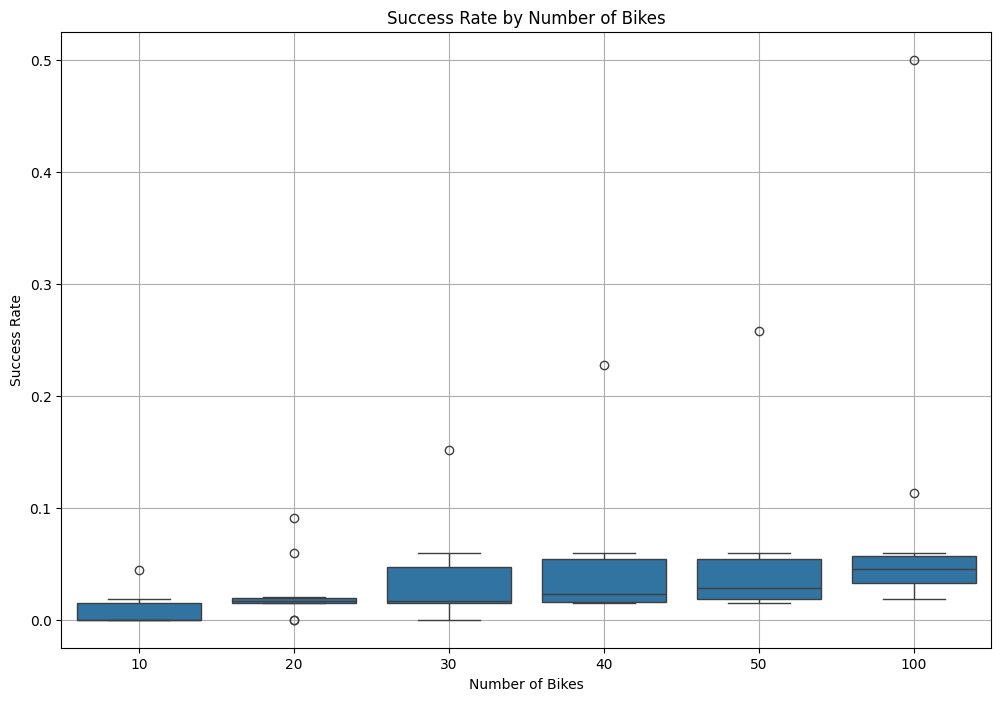

In [ ]:
# 結果をDataFrameに変換
results_df = pd.DataFrame(results, columns=['Bike Count', 'Max Distance', 'Success Rate'])

# 成功率のグラフをプロット
# plt.figure(figsize=(10, 6))
# for dist in max_distances:
#     subset = results_df[results_df['Max Distance'] == dist]
#     plt.plot(subset['Bike Count'], subset['Success Rate'], label=f'Max Distance = {dist} degrees')

# 箱ひげ図の描画
plt.figure(figsize=(12, 8))
sns.boxplot(x='Bike Count', y='Success Rate', data=results_df)
plt.title('Success Rate by Number of Bikes')
plt.xlabel('Number of Bikes')
plt.ylabel('Success Rate')
plt.grid(True)
plt.show()

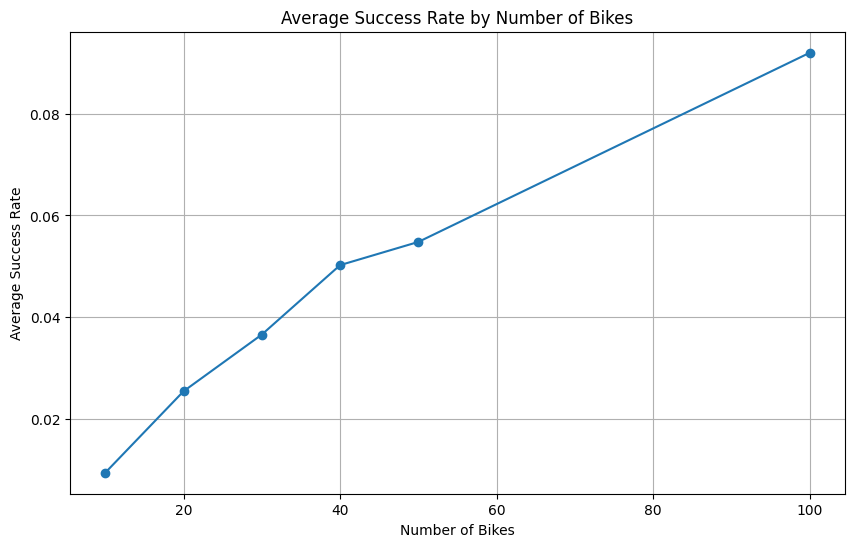

In [ ]:
# 各自転車数ごとにSuccess Rateの平均を計算
average_success_rates = results_df.groupby('Bike Count')['Success Rate'].mean().reset_index()

# 線グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(average_success_rates['Bike Count'], average_success_rates['Success Rate'], marker='o')
plt.title('Average Success Rate by Number of Bikes')
plt.xlabel('Number of Bikes')
plt.ylabel('Average Success Rate')
plt.grid(True)
plt.show()